In [52]:
import torch as tc 
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, random_split 


import torchvision as tv 
from torchvision import transforms as T 
from torchvision import datasets 
from torchvision import models 

from torchmetrics import Accuracy

from tqdm import tqdm 

import numpy as np 
import matplotlib.pyplot as plt 

import copy

In [53]:
device = 'cuda' if tc.cuda.is_available() else 'cpu'
device

'cuda'

In [54]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [55]:
def train_one_epoch(student_model, teacher_model, train_loader, loss_func, optimizer, shedular, epoch):
    student_model.train()

    train_loss=AverageMeter()
    train_acc=Accuracy(task='multiclass', num_classes=10).to(device)

    with tqdm(train_loader, unit='batch') as tepoch:
        for x, y in tepoch:
            if epoch is not None:
                tepoch.set_description(f'Epoch={epoch}')
                
            optimizer.zero_grad()

            x = x.to(device)
            y = y.to(device)
 
            student_output = student_model(x)
            with tc.no_grad():
                teacher_output = teacher_model(x)

            loss = loss_func(student_output, teacher_output,  y)
            loss.backward()
            optimizer.step()
            shedular.step()
            

            train_loss.update(loss.item())
            train_acc(student_output.squeeze(), y.int())

            tepoch.set_postfix(loss=train_loss.avg, Accuracy=train_acc.compute().item() * 100)

    return student_model, train_loss.avg, train_acc.compute().item() * 100

In [56]:
def validation(model, valid_loaedr, loss_func):
    model.eval()

    valid_loss=AverageMeter()
    valid_acc=Accuracy(task='multiclass', num_classes=10).to(device)

    for x, y in valid_loaedr:

        x=x.to(device)
        y=y.to(device)

        yp=model(x)
        loss=loss_func(yp.squeeze(), y)

        valid_loss.update(loss.item())
        valid_acc(yp.squeeze(), y)

    print(f'valid loss={valid_loss.avg:.4}, accuracy={valid_acc.compute().item() * 100 :.4}')
    print()

    return valid_loss.avg, valid_acc.compute().item() * 100

In [57]:
train_transform = T.Compose([T.RandomCrop(32, 4),
                             T.RandomHorizontalFlip(),
                             T.ToTensor(),
                             T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

test_transform = T.Compose([T.ToTensor(), 
                            T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

In [58]:
train_dataset = datasets.CIFAR10(root =  '/home/ahmadrezabaqerzadeh/datasets/', train = True, download = True, transform = train_transform)
test_dataset  = datasets.CIFAR10(root = '/home/ahmadrezabaqerzadeh/datasets/', train = False, download = True, transform = test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [59]:
train_loader = DataLoader(train_dataset, batch_size = 128, shuffle = True, num_workers = 2)
test_loader  = DataLoader(test_dataset, batch_size = 100, shuffle = False, num_workers = 2)

In [60]:
teacher_model = models.mobilenet_v2() 
teacher_model.classifier[1] = nn.Linear(1280, 10)
teacher_model.load_state_dict(tc.load('/home/ahmadrezabaqerzadeh/AI/git/repo18/KnowledgeDistillation/models/TeacherModel.pt'))
teacher_model = teacher_model.requires_grad_(False)

In [61]:
for name, param in teacher_model.named_parameters():
    print(name, param.requires_grad)

features.0.0.weight False
features.0.1.weight False
features.0.1.bias False
features.1.conv.0.0.weight False
features.1.conv.0.1.weight False
features.1.conv.0.1.bias False
features.1.conv.1.weight False
features.1.conv.2.weight False
features.1.conv.2.bias False
features.2.conv.0.0.weight False
features.2.conv.0.1.weight False
features.2.conv.0.1.bias False
features.2.conv.1.0.weight False
features.2.conv.1.1.weight False
features.2.conv.1.1.bias False
features.2.conv.2.weight False
features.2.conv.3.weight False
features.2.conv.3.bias False
features.3.conv.0.0.weight False
features.3.conv.0.1.weight False
features.3.conv.0.1.bias False
features.3.conv.1.0.weight False
features.3.conv.1.1.weight False
features.3.conv.1.1.bias False
features.3.conv.2.weight False
features.3.conv.3.weight False
features.3.conv.3.bias False
features.4.conv.0.0.weight False
features.4.conv.0.1.weight False
features.4.conv.0.1.bias False
features.4.conv.1.0.weight False
features.4.conv.1.1.weight False
fea

In [62]:
teacher_model = teacher_model.to(device)
teacher_model.eval()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [63]:
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(400, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)
        
    def forward(self, x):
        
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = nn.Dropout(0.1)(self.fc(out))
        out = self.relu(out)
        out = nn.Dropout(0.1)(self.fc1(out))
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [64]:
student_model = LeNet5(10).to(device)

In [65]:
optimizer = optim.SGD(student_model.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 5e-4)
shedular  = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 40000, eta_min = 1e-7)

In [66]:
def loss_func_train(student_output, teacher_output, y):
    alpha = 0.1
    Tem   = 1.5
    error = nn.KLDivLoss(reduction = 'batchmean')(nn.LogSoftmax(dim = 1)(student_output/Tem), nn.Softmax(dim = 1)(teacher_output/Tem)) * (alpha * Tem * Tem) + nn.CrossEntropyLoss()(student_output.squeeze(), y) * (1 - alpha)
    return error
loss_func = nn.CrossEntropyLoss()

In [67]:
loss_train_hist, acc_train_hist = [], []
loss_valid_hist, acc_valid_hist = [], []

best_acc   = 0
best_model = [0]

In [74]:
start, end = 90, 100
for i in range(start, end):

  student_model, train_loss, train_acc = train_one_epoch(student_model, teacher_model, train_loader, loss_func_train, optimizer, shedular, i)
  valid_loss, valid_acc = validation(student_model,test_loader,loss_func)

  acc_train_hist.append(train_acc)
  loss_train_hist.append(train_loss)

  acc_valid_hist.append(valid_acc)
  loss_valid_hist.append(valid_loss)

  if valid_acc>best_acc:
    best_acc = valid_acc 
    best_model[0] = copy.deepcopy(student_model)
    print('model saved!')

Epoch=90: 100%|██████████| 391/391 [00:11<00:00, 34.97batch/s, Accuracy=71.5, loss=0.846]


valid loss=0.7887, accuracy=72.81

model saved!


Epoch=91: 100%|██████████| 391/391 [00:11<00:00, 34.08batch/s, Accuracy=71.3, loss=0.851]


valid loss=0.7899, accuracy=72.65



Epoch=92: 100%|██████████| 391/391 [00:11<00:00, 33.83batch/s, Accuracy=71.3, loss=0.845]


valid loss=0.7904, accuracy=72.76



Epoch=93: 100%|██████████| 391/391 [00:12<00:00, 32.50batch/s, Accuracy=71.3, loss=0.848]


valid loss=0.7888, accuracy=72.78



Epoch=94: 100%|██████████| 391/391 [00:11<00:00, 33.82batch/s, Accuracy=71.4, loss=0.845]


valid loss=0.7902, accuracy=72.72



Epoch=95: 100%|██████████| 391/391 [00:12<00:00, 32.33batch/s, Accuracy=71.2, loss=0.846]


valid loss=0.7843, accuracy=72.64



Epoch=96: 100%|██████████| 391/391 [00:11<00:00, 32.68batch/s, Accuracy=71.5, loss=0.838]


valid loss=0.7942, accuracy=73.09

model saved!


Epoch=97: 100%|██████████| 391/391 [00:11<00:00, 33.19batch/s, Accuracy=71.4, loss=0.842]


valid loss=0.793, accuracy=72.62



Epoch=98: 100%|██████████| 391/391 [00:11<00:00, 33.34batch/s, Accuracy=71.1, loss=0.844]


valid loss=0.7886, accuracy=72.46



Epoch=99: 100%|██████████| 391/391 [00:11<00:00, 33.19batch/s, Accuracy=71.3, loss=0.842]


valid loss=0.789, accuracy=73.01



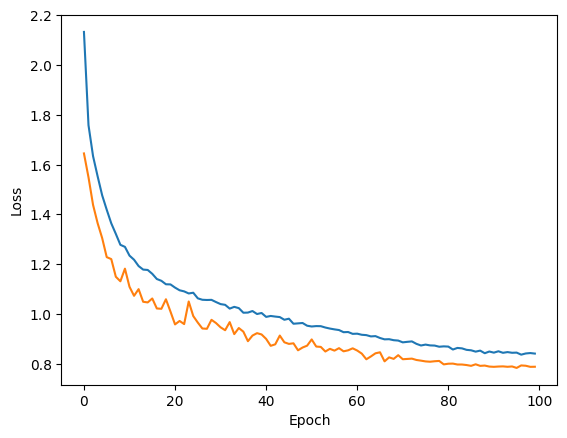

In [75]:
plt.plot(range(end), loss_train_hist, label = 'Train Loss') 
plt.plot(range(end), loss_valid_hist, label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

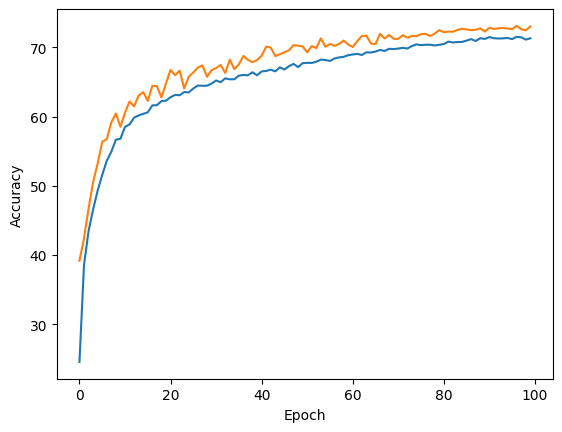

In [76]:
plt.plot(range(end), acc_train_hist, label = 'Train Accurcay') 
plt.plot(range(end), acc_valid_hist, label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [79]:
max(acc_valid_hist)

73.089998960495